# Estimating the 3D structure of basking shark heads

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/morphomatics/3Dfrom2DLandmarks/HEAD?filepath=example_basking_shark.ipynb) Launch live version of this notebook.

This example notebook is part of the publication:
> M. Paskin, D. Baum, Mason N. Dean, Christoph von Tycowicz (2022)
> **[A Kendall Shape Space Approach to 3D Shape Estimation from 2D Landmarks -- Source Code and Data.](https://github.com/morphomatics/3Dfrom2DLandmarks)**</br>
> [![DOI](https://img.shields.io/badge/DOI-10.12752/8730-yellow)](http://dx.doi.org/10.12752/8730)

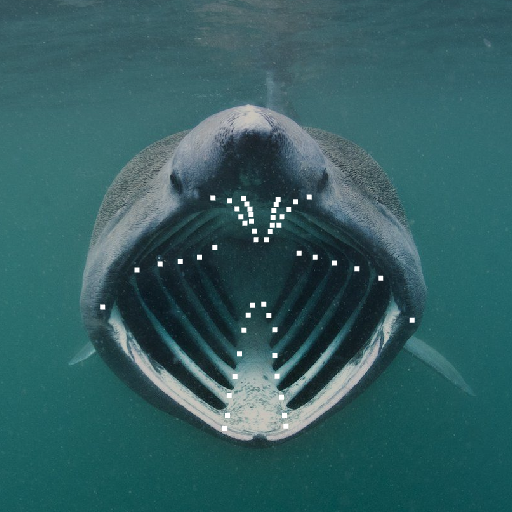

In [40]:
import numpy as np
import pyvista as pv

# read image as texture
tex = pv.read_texture('./data/shark.jpg')
dims = tex.to_array().shape

# read annotated 2D landmarks
W = np.load('./data/shark_2D_landmarks.npy')
W[:,1] = dims[1] - W[:,1]

# show image and 2D landmarks
plt = pv.Plotter(notebook=True)
billboard = pv.Plane(center=[dims[0]/2, dims[1]/2, 0], i_size=dims[0], j_size=dims[1])
plt.add_mesh(billboard, texture=tex)
plt.add_mesh(pv.PolyData(np.c_[W, np.zeros(len(W))]))
plt.view_xy()
plt.camera.zoom(2)
plt.show(window_size=(512,512), jupyter_backend='static')

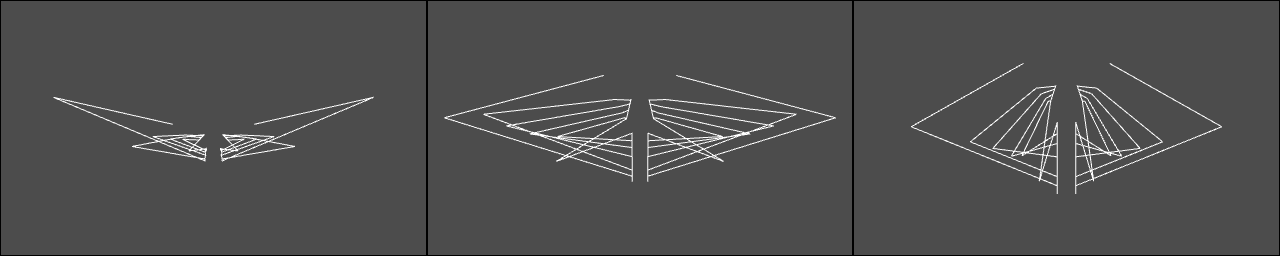

In [79]:
# read basis shapes
basisShapes = np.load('./data/baskingShark_basisShapes.npy').astype(np.float64)

# read adjacency of landmarks w.r.t. joining skeletal components
adj = np.load('./data/adjacency.npy')
edges = np.c_[np.full(len(adj),2), adj]
pv.global_theme.edge_color = 'white'

# show
plt = pv.Plotter(notebook=True, shape=(1,3))
for i in range(3):
    plt.subplot(0, i)
    plt.add_mesh(pv.PolyData(basisShapes[i*5], edges), show_edges=True)
    plt.view_xy()
    plt.camera.zoom(4)
plt.show(jupyter_backend='static', window_size=(1280,256))

In [57]:
%env JAX_PLATFORM_NAME=cpu

from morphomatics.manifold import Kendall
from shape_estimation import ShapeEstimation

# 3D Kendall shape space
mfd = Kendall(shape=basisShapes[0].shape)

# map landmarks to (2D) Kendall shape space
w = Kendall.project(W)

# estimate 3D shape for given landmarks
shapeFrom2d = ShapeEstimation(w, basisShapes)
shape = shapeFrom2d.optimize(verbose=2)

env: JAX_PLATFORM_NAME=cpu
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.3095877468585968e-01    1.85924441e-01    
 2           +1.3240520656108856e-01    7.81049430e-02    
 3           +1.3152003288269043e-01    5.73482551e-02    
 4           +1.2936756014823914e-01    1.09812105e-02    
 5           +1.2935090065002441e-01    9.96226817e-03    
 6           +1.2930396199226379e-01    4.09402186e-03    
 7           +1.2929467856884003e-01    8.71213851e-04    
 8           +1.2929424643516541e-01    2.82604189e-04    
 9           +1.2929418683052063e-01    7.06439751e-05    
10           +1.2929418683052063e-01    6.81228339e-05    
Terminated - max iterations reached after 0.13 seconds.

Cost:  0.028474139
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.8474139049649239e-02    3.9

Now let's put all of it together.

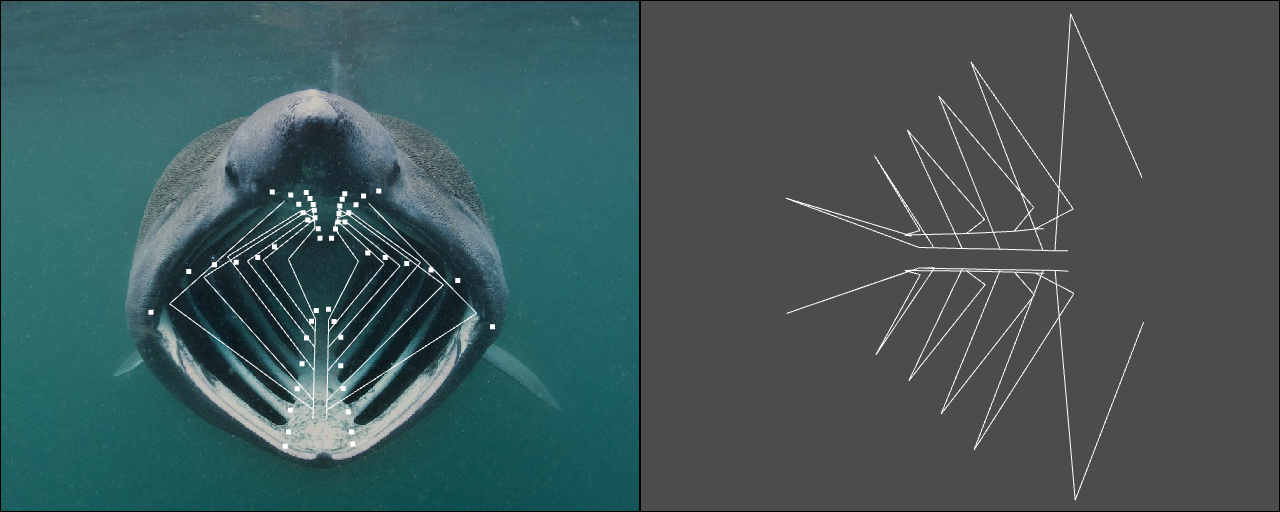

In [80]:
# move/scale estimated shape to input landmarks
CoG = W.mean(axis=0)
S = np.asarray(shape) * np.linalg.norm(W-CoG) + np.r_[CoG, 1000]
# create mesh
S = pv.PolyData(S, edges)

# plot
plt = pv.Plotter(notebook=True, shape=(1, 2))

# frontal view
plt.subplot(0, 0)

# add estimated shape, image and 2d landmarks
plt.add_mesh(S, show_edges=True)
plt.add_mesh(billboard, texture=tex)
plt.add_mesh(pv.PolyData(np.c_[W, np.zeros(len(W))]))

# setup camera
plt.enable_parallel_projection()
plt.view_xy()
plt.camera.zoom(4)

# side view
plt.subplot(0, 1)

# add estimated shape
plt.add_mesh(S, show_edges=True)

# setup camera
plt.view_zx()
plt.camera.zoom(2)

plt.show(jupyter_backend='static', window_size=(1280, 512))